In [ ]:
import numpy as np

# setting the seed allows for reproducible results
np.random.seed(123)

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

import pandas as pd
import matplotlib.pyplot as plt
import math
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [ ]:
def rpr_predict_next_relative(given_price, theta = 0.8):
  n = len(given_price)
  prev_pred = given_price[1]/given_price[0]
  prev_rel = given_price[1]/given_price[0]

  for i in range(1,n):
    prev_rel = given_price[i]/given_price[i-1]
    gamma = theta*prev_rel/(theta*prev_rel + prev_pred)
    pred = gamma + (1 - gamma)*(prev_pred/prev_rel)
    prev_pred = pred*1

  return prev_pred

In [ ]:
class Model:
    def __init__(self):
        self.data = None
        self.model = None
        self.final_ratio = None
        self.cov = None
        self.exp_return = None

    def sharpe_loss(self, y_true, y_pred):

        a = self.exp_return.reshape(1, -1) @ y_pred.reshape(-1, 1)
        b = self.cov @ y_pred.reshape(-1, 1)
        c = y_pred.reshape(1, -1) @ b.reshape(-1, 1)
        d = tf.math.sqrt(c)

        sharpe = a / d
        return -sharpe

    def __build_model(self, input_shape, outputs, l_rate):

        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='softmax')
        ])

        Opt = Adam(learning_rate = l_rate)
        model.compile(loss=self.sharpe_loss, optimizer=Opt)
        return model

    def get_allocations(self, data: pd.DataFrame, lr=0.1, ep=20):

        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)

        temparr = data.to_numpy()
        return_rate = (temparr[:-1] - temparr[1:])/temparr[1:]
        exp_return = (rpr_predict_next_relative(temparr) - 1)

        cov = np.cov(np.transpose(return_rate))

        data = data.iloc[1:]

        self.data = tf.cast(tf.constant(data), float)
        self.exp_return = tf.convert_to_tensor(exp_return, tf.float32)
        self.cov = tf.convert_to_tensor(cov, tf.float32)

        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns), l_rate = lr)

        fit_predict_data = data_w_ret[np.newaxis,:]
        history = self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=ep, shuffle=False)
        self.final_ratio = -history.history['loss'][-1]
        return self.model.predict(fit_predict_data)[0]

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/OMF_data_final/uploaded_data_2/Dataset_2_csv.csv')
df = df[df.columns[1:]]
df = df.iloc[::-1]

In [ ]:
window = 30
num_days = len(df.index)
num_companies = df.columns.size
total_rows = num_days - window + 1

In [ ]:
lr = 0.1
num_epochs = 20

In [ ]:
weights = []

In [ ]:
for itr in range(total_rows):
  tempdf = df.iloc[itr:itr+window]
  temparr = tempdf.to_numpy()
  return_rate = (temparr[:-1] - temparr[1:])/temparr[1:]

  m = Model()
  w = m.get_allocations(tempdf,lr,num_epochs)
  weights.append(w)

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: -0.0606
Epoch 2/20
1/1 [==============================] - 0s 20ms/step - loss: -0.2366
Epoch 3/20
1/1 [==============================] - 0s 27ms/step - loss: -0.4184
Epoch 4/20
1/1 [==============================] - 0s 24ms/step - loss: -0.6505
Epoch 5/20
1/1 [==============================] - 0s 22ms/step - loss: -0.8791
Epoch 6/20
1/1 [==============================] - 0s 23ms/step - loss: -1.0211
Epoch 7/20
1/1 [==============================] - 0s 25ms/step - loss: -1.1044
Epoch 8/20
1/1 [==============================] - 0s 24ms/step - loss: -1.1852
Epoch 9/20
1/1 [==============================] - 0s 23ms/step - loss: -1.1957
Epoch 10/20
1/1 [==============================] - 0s 22ms/step - loss: -1.2113
Epoch 11/20
1/1 [==============================] - 0s 23ms/step - loss: -1.2233
Epoch 12/20
1/1 [==============================] - 0s 27ms/step - loss: -1.2109
Epoch 13/20
1/1 [==============================] - 

1/1 [==============================] - 0s 419ms/step
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.1634
Epoch 2/20
1/1 [==============================] - 0s 27ms/step - loss: -0.0434
Epoch 3/20
1/1 [==============================] - 0s 28ms/step - loss: -0.1298
Epoch 4/20
1/1 [==============================] - 0s 32ms/step - loss: -0.4647
Epoch 5/20
1/1 [==============================] - 0s 26ms/step - loss: -0.6921
Epoch 6/20
1/1 [==============================] - 0s 27ms/step - loss: -0.8195
Epoch 7/20
1/1 [==============================] - 0s 35ms/step - loss: -0.8594
Epoch 8/20
1/1 [==============================] - 0s 28ms/step - loss: -0.8733
Epoch 9/20
1/1 [==============================] - 0s 30ms/step - loss: -0.8760
Epoch 10/20
1/1 [==============================] - 0s 26ms/step - loss: -0.8773
Epoch 11/20
1/1 [==============================] - 0s 27ms/step - loss: -0.8772
Epoch 12/20
1/1 [==============================] - 0s 25ms/step - loss: -0.8751

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step - loss: -1.8411
Epoch 3/20
1/1 [==============================] - 0s 37ms/step - loss: -2.4324
Epoch 4/20
1/1 [==============================] - 0s 34ms/step - loss: -2.5138
Epoch 5/20
1/1 [==============================] - 0s 33ms/step - loss: -2.4394
Epoch 6/20
1/1 [==============================] - 0s 30ms/step - loss: -2.3224
Epoch 7/20
1/1 [==============================] - 0s 28ms/step - loss: -2.2272
Epoch 8/20
1/1 [==============================] - 0s 31ms/step - loss: -2.3389
Epoch 9/20
1/1 [==============================] - 0s 29ms/step - loss: -2.2594
Epoch 10/20
1/1 [==============================] - 0s 33ms/step - loss: -2.2664
Epoch 11/20
1/1 [==============================] - 0s 28ms/step - loss: -2.2725
Epoch 12/20
1/1 [==============================] - 0s 26ms/step - loss: -2.2964
Epoch 13/20
1/1 [==============================] - 0s 29ms/step - loss: -2.2446
Epoch 14

In [ ]:
weights = np.array(weights)

In [ ]:
result = pd.DataFrame(weights)
result.to_csv('Weights with rpr return')

In [ ]:
result

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,5.320498e-08,1.405702e-07,2.283298e-09,9.280052e-06,6.658620e-06,2.160827e-05,8.684141e-11,1.004623e-10,1.200593e-10,2.642587e-07,...,1.060473e-08,1.973781e-09,2.304645e-10,3.112346e-01,1.182701e-10,7.843557e-06,2.969737e-08,6.944775e-11,8.016874e-10,6.981271e-11
1,1.464990e-17,2.901319e-13,3.189875e-13,1.691868e-18,1.357447e-06,3.472314e-12,1.843510e-19,6.013404e-19,2.298184e-18,9.162787e-12,...,8.739067e-10,1.594984e-11,2.703805e-10,1.337674e-18,1.318615e-16,2.558470e-07,2.615287e-12,1.316985e-18,3.274215e-13,1.336827e-18
2,4.705570e-10,3.185041e-10,1.425931e-10,3.272954e-13,4.622504e-13,3.535962e-11,5.786550e-13,1.356090e-12,6.116246e-13,4.115286e-13,...,5.942709e-01,9.739255e-12,3.329107e-05,6.611675e-13,6.543340e-13,7.764480e-10,2.890178e-10,3.492424e-13,6.409306e-13,1.083987e-12
3,1.145852e-10,5.811900e-12,1.480059e-10,1.667102e-08,5.140274e-09,1.020798e-06,1.358495e-10,3.414940e-12,3.480313e-09,2.406608e-09,...,3.479589e-04,1.216231e-10,2.345091e-09,3.575217e-12,2.160003e-09,3.864839e-12,5.752024e-10,3.001205e-07,4.370323e-09,1.016820e-09
4,2.847063e-09,4.742403e-05,9.444154e-09,4.901905e-07,2.985281e-04,3.326664e-06,8.295284e-08,3.870523e-10,2.346767e-06,2.429182e-09,...,3.502316e-08,1.415813e-10,2.257815e-10,4.355291e-10,2.158903e-09,9.732249e-02,1.059704e-09,2.308337e-09,1.097168e-05,1.449001e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,3.402328e-05,3.328213e-03,1.753217e-01,1.157975e-01,1.552505e-03,1.008343e-06,2.063554e-08,6.015880e-08,1.128523e-07,1.198571e-07,...,3.509510e-08,1.125535e-05,4.104834e-04,4.088106e-04,1.156500e-08,5.507860e-08,7.317119e-08,3.934176e-07,3.356699e-08,6.965095e-07
216,2.374020e-09,1.774723e-08,2.501175e-09,1.167499e-04,2.368675e-08,2.513273e-05,7.844569e-08,9.182027e-09,9.308637e-09,2.957737e-08,...,1.038876e-07,2.180646e-01,8.653334e-09,4.743354e-09,8.290240e-09,1.388841e-08,8.139418e-09,6.770702e-08,9.334951e-09,2.225330e-08
217,1.627665e-06,7.752109e-07,2.446534e-09,2.567308e-08,2.798952e-09,1.495468e-08,7.136227e-07,4.346993e-09,7.086423e-10,3.171670e-06,...,2.089714e-07,4.891113e-06,3.811461e-09,4.144363e-09,1.282821e-08,2.341889e-09,3.306897e-09,5.763494e-07,7.131589e-10,1.847526e-09
218,1.051591e-07,2.127549e-04,6.137559e-09,1.716022e-03,8.635158e-10,3.357324e-09,8.788982e-09,1.603212e-08,1.714551e-08,2.672704e-08,...,2.526954e-06,8.701866e-08,3.313559e-07,1.213560e-09,3.537785e-09,2.237640e-01,4.028984e-04,1.174027e-07,4.252709e-09,6.882005e-09


## Checking Actual Returns

In [ ]:
prices = df.to_numpy()

In [ ]:
return_rate = (prices[1:] - prices[:-1])/prices[:-1]

In [ ]:
weights = weights[:-1]

In [ ]:
return_at_weight = []

In [ ]:
day = []

In [ ]:
for i in range(window, total_rows):
  r = weights[i-window]@return_rate[i]
  return_at_weight.append(r)
  day.append(i-window+1)

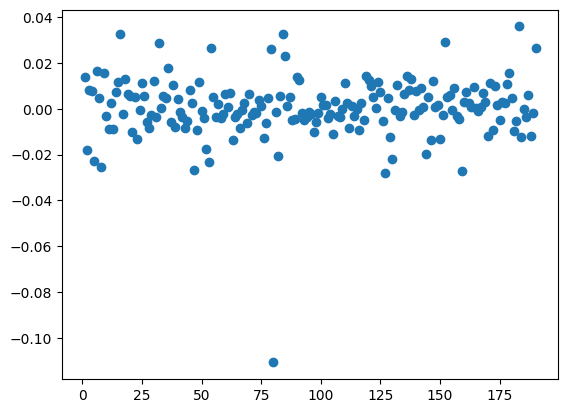

In [ ]:
plt.plot(day,return_at_weight,'o')
plt.show()

In [ ]:
print(sum(return_at_weight))

0.07938247864343598


In [ ]:
# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
# 0.20734058

In [ ]:
def remove_outliers(data, threshold=3):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    return [x for x, z in zip(data, z_scores) if z <= threshold]

In [ ]:
return_update = remove_outliers(return_at_weight)

In [ ]:
print(sum(return_update))

0.19005089436130781
